# Kaupunkipyörien käyttö

Tässä projektissa tutkin kaupunkipyörien käyttöä Espoossa ja Helsingissä vuonna 2019. Kaupunkipyörien käyttö oli mahdollista huhtikuusta lokakuuhun. Kuukausittainen käyttödata on saatavilla hsl.fi/avoindata (2.1.2019).

In [2]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr   

Ensimmäisenä muokkaan dataa luettavaan muotoon. Poistin datasta matkat, joissa pyöräilty matka oli 0m. Luultavasti tällöin pyörässä on ollut jotakin vikaa enkä täten ole kiinnostunut noista matkoista.

Funktio ```read_data(month)``` saa parametrikseen halutun kuukauden, joka tulee olla muodossa "month" eli huhtikuu tulee olla syötetty muodossa "04". Funktio muokkaa kuukausidatasta sarakkaiden nimet helpommin käytettävään muotoon, välit on korvattu alaviivalla. Rivit, joissa taitettu matka on 0m poistetaan. 

Funktio ```year_data()``` liittää muokatut kuukausidatat yhdeksi dataksi. Puolestaan ```data_dates(month)``` jakaa sarakkeen 'Departure' kahdeksi sarakkeeksi. Nämä uudet sarakkeet ovat 'Date_Departure', joka sisältää lähtö päivämäärän ja 'Time_Departure', joka sisältää lähtö kellon ajan. Lisäksi lisätään uusi sarake Weekday_Return, joka sisältää lähtöpäivämäärästä selvitetyn viikonpäivän. Arvo 1 vastaa maanantaita, 2 tiistaita jne.  Funktio ```data_dates_year()``` toimii vastaavalla tavalla kuin funktio data_dates(month).

In [3]:
def read_data(month):
    file = "2019-"+month+".csv"
    data = pd.read_csv(file,sep=',')
    #Replace spaces from columns' names
    data.columns = data.columns.str.replace(' ', '_')
    #Delete rows where covered distance was 0m
    data = data[data['Covered_distance_(m)'] != 0]
    #data = data[data['Departure_station_id'] != data['Return_station_id']]
    return data

def year_data():
    months = [read_data("04"),read_data("05"),read_data("06"),
              read_data("07"),read_data("08"),read_data("09"),read_data("10")]
    return pd.concat(months)


def data_dates(month):
    data = read_data(month)
    data[['Date_Departure', 'Time_Departure']] = data.Departure.str.split('T',expand=True)
    data['Date_Departure'] = pd.to_datetime(data['Date_Departure'])
    data['Weekday_Departure'] = data['Date_Departure'].dt.day_name()
    
    data[['Date_Return', 'Time_Return']] = data.Return.str.split('T',expand=True)
    data['Date_Return'] = pd.to_datetime(data['Date_Return'])
    data['Weekday_Return'] = data['Date_Return'].dt.day_name()
    return data

def data_dates_year():
    data = year_data()
    data[['Date_Departure', 'Time_Departure']] = data.Departure.str.split('T',expand=True)
    data['Date_Departure'] = pd.to_datetime(data['Date_Departure'])
    data['Weekday_Departure'] = data['Date_Departure'].dt.day_name()
    
    data[['Date_Return', 'Time_Return']] = data.Return.str.split('T',expand=True)
    data['Date_Return'] = pd.to_datetime(data['Date_Return'])
    data['Weekday_Return'] = data['Date_Return'].dt.day_name()
    return data

if __name__ == "__main__":
    print(data_dates_year().columns)

Index(['Departure', 'Return', 'Departure_station_id', 'Departure_station_name',
       'Return_station_id', 'Return_station_name', 'Covered_distance_(m)',
       'Duration_(sec.)', 'Date_Departure', 'Time_Departure',
       'Weekday_Departure', 'Date_Return', 'Time_Return', 'Weekday_Return'],
      dtype='object')


## Matkat

Ensimmäisenä tulostan datasta perustiedot; keskiarvot, minimit ja maksimit funktiossa ```basic_stat()```. Sen jälkeen tutkin, kuinka monta matkaa on tehty kunakin kuukautena. Matka katsotaan alkaneeksi, kun käyttäjä aktivoi pyörän, ja päättyneen kun hän palauttaa sen asemalle. Matkoissa ei ole huomioitu sitä, että käyttäjä palauttaa ja aktivoi pyörän uudelleen heti palautuksen jälkeen jatkaen näin vielä matkaa. Tälläisiä jatkuneita matkoja on oletettavasti datassa, sillä matka saa kestää 30min ilman lisämaksuja. Matkojen lukumäärät esitän alla olevassa kuvaajassa, jossa y-akselilla on matkojen lukumäärät ja x-akselilla kuukaudet. Funktio ```plot_yearly_trips()``` piirtää kyseisen kuvaajan.

       Departure_station_id  Return_station_id  Covered_distance_(m)  \
count          3.687714e+06       3.687714e+06          3.687714e+06   
mean           1.665614e+02       1.664500e+02          2.141165e+03   
std            2.001197e+02       2.002980e+02          3.630553e+03   
min            1.000000e+00       1.000000e+00         -4.290436e+06   
25%            3.600000e+01       3.500000e+01          1.014000e+03   
50%            8.600000e+01       8.600000e+01          1.711000e+03   
75%            2.020000e+02       2.020000e+02          2.823000e+03   
max            9.970000e+02       9.970000e+02          3.589426e+06   

       Duration_(sec.)  
count     3.687714e+06  
mean      9.470662e+02  
std       8.196541e+03  
min       7.000000e+00  
25%       3.380000e+02  
50%       5.660000e+02  
75%       9.410000e+02  
max       5.401659e+06  


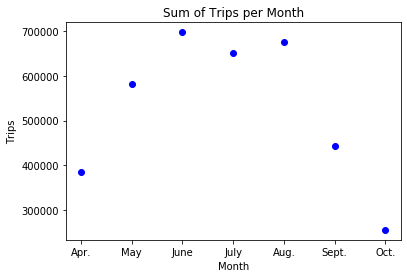

In [35]:
def basic_stat():
    data = year_data()
    return data.describe()


def plot_yearly_trips():
    size_04 = len(read_data("04").index)
    size_05 = len(read_data("05").index)
    size_06 = len(read_data("06").index)
    size_07 = len(read_data("07").index)
    size_08 = len(read_data("08").index)
    size_09 = len(read_data("09").index)
    size_10 = len(read_data("10").index)
    
    months = ["Apr.","May","June","July","Aug.","Sept.","Oct."]
    sizes = [size_04,size_05,size_06,size_07,size_08,size_09,size_10]
    plt.plot(months, sizes, 'bo')
    plt.xlabel('Month')
    plt.ylabel('Trips')
    plt.title('Sum of Trips per Month')
    plt.show()

if __name__ == "__main__":
    print(basic_stat())
    plot_yearly_trips()
    

Yhteensä matkoja on tehty pyöräilykautena noin 3 700 000. Keskimääräinen matkan pituus on ollut 2.14km ja aika noin 16 minuuttia.

Kuvaajasta voidaan huomata kuinka matkojen määrä on noussut kesäkuukausia kohti ja laskee elokuun jälkeen rajusti lokakuuhun mentäessä.

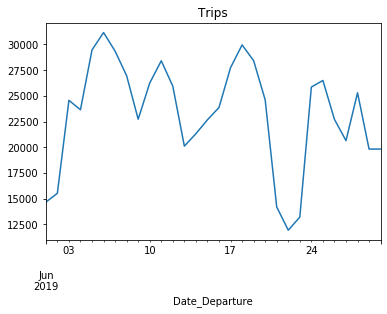

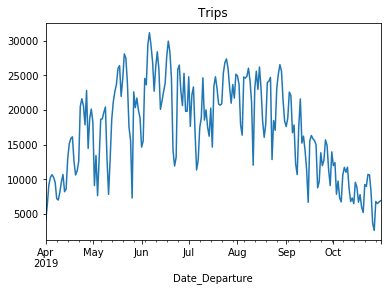

In [5]:
def trip_per_date(month):
    data = data_dates(month)
    return data.groupby(['Date_Departure']).size()

def plot_trip_per_date(month):
    df = trip_per_date(month)
    df.plot()
    plt.title("Trips")
    plt.show()
    
def plot_trip_per_date_year():
    df = data_dates_year().groupby(['Date_Departure']).size()
    df.plot()
    plt.title("Trips")
    plt.show()
    
    
if __name__ == "__main__":
    plot_trip_per_date("06")
    plot_trip_per_date_year()
    
    

    

Kuvaajassa tulee selkeästi säännöllisesti laskevia piikkejä. Haluan tutkia asettuvatko nämä piikit viikonloppujen kohdalle. Ensiksi lasken keskimääräisen matkojen lukumäärän eri viikonpäivinä.

In [9]:
def trip_weekday(day):
    data = data_dates_year()
    data = data.groupby(['Weekday_Departure'])
    trips = data['Date_Departure'].count()[day]
    days = len(data['Date_Departure'].unique()[day])
    return (trips/days,day)
if __name__ == "__main__":
    trip_mean = [trip_weekday("Monday"),trip_weekday("Tuesday"),trip_weekday("Wednesday"),trip_weekday("Thursday"),trip_weekday("Friday"),trip_weekday("Saturday"), trip_weekday("Sunday")] 
    print(sorted(trip_mean))


[(13404.0, 'Sunday'), (14682.666666666666, 'Saturday'), (17292.9, 'Friday'), (17858.483870967742, 'Monday'), (18711.25806451613, 'Thursday'), (18867.935483870966, 'Tuesday'), (19605.129032258064, 'Wednesday')]


Kuten arvelinkin viikonloppuisin käyttömäärät ovat pienempiä kuin muina arkipäivinä. Hieman yllättävää on, että keskiviikko nousee suosituimmaksi pyöräilypäiväksi. Viikonloppuina käyttömäärät on oletettavasti pienemmät sillä työmatkapyöräilijöitä on luultavasti huomattavasti arkipäiviä vähemmän.

Selvitään seuraavaksi suosituimmat lähtö- ja pääteasemat. Funktio ```top_departure_stations(month,n)``` saa parameterikseen tarkasteltavan kuukauden ja lukumäärän, kuinka monta suosituinta lähtöasemaa haluaa palauttaa. Funktio ```top_return_stations(month,n)``` toimii vastaavasti suosituimmille päätesemille ja vuosittaiset suosituimmat asemat voi selvittää funktioilla ```top_departure_stations_year(n)``` ja ```top_return_stations_year(n)```. Funktiossa ```popular_trip()``` selvitetään suosituimmat lähtö- ja pääteasema yhdistelmät.

In [14]:
def top_departure_stations(month,n):
    data = read_data(month)
    return data['Departure_station_name'].value_counts()[:n].index.tolist()

def top_return_stations(month,n):
    data = read_data(month)
    return data['Return_station_name'].value_counts()[:n].index.tolist()

def top_departure_stations_year(n):
    data = year_data()
    return data['Departure_station_name'].value_counts()[:n].index.tolist()

def top_return_stations_year(n):
    data = year_data()
    return data['Return_station_name'].value_counts()[:n].index.tolist()

def popular_trip():
    data = year_data()
    return data.groupby(['Departure_station_name','Return_station_name']).size().sort_values(ascending=False)

if __name__ == "__main__":
    print(top_departure_stations_year(9))
    print(top_return_stations_year(9))
    print(popular_trip())
    
    


['Töölönlahdenkatu', 'Itämerentori', 'Rautatientori / länsi', 'Ympyrätalo', 'Rautatientori / itä', 'Porthania', 'Aalto-yliopisto (M), Korkeakouluaukio', 'Kamppi (M)', 'Hietalahdentori']
['Töölönlahdenkatu', 'Itämerentori', 'Rautatientori / länsi', 'Ympyrätalo', 'Rautatientori / itä', 'Porthania', 'Aalto-yliopisto (M), Korkeakouluaukio', 'Kamppi (M)', 'Kanavaranta']
<bound method NDFrame.head of Departure_station_name                 Return_station_name                  
Aalto-yliopisto (M), Korkeakouluaukio  Jämeräntaival                            14168
Jämeräntaival                          Aalto-yliopisto (M), Korkeakouluaukio    13780
Itämerentori                           Salmisaarenranta                          7683
Itälahdenkatu                          Gyldenintie                               7057
Gyldenintie                            Itälahdenkatu                             6917
Itämerentori                           Tyynenmerenkatu                           5925
Salmisaar

Suosituimmat lähtö- ja saapumisasemat ovat hyvin pitkälti samassa järjestyksessä. Vasta kymmenes lähtö- ja saapumisasema eroaa toisistaan. Selvästi suosituimmat lähtö-pääteasema yhdistelmät ovat Aalto-yliopisto (M), Korkeakouluaukio - Jämeräntaival sekä Jämeräntaival - Aalto-yliopisto (M), Korkeakouluaukio. Jämeräntiellä on paljon opiskelija-asuntoja, joten tästä voisi päätellä, että opiskelijat pyöräilevät paljon yliopiston läheisyyteen. 

## Pyöräilynopeus ja matkan pituus

Seuraavaksi lasken keskinoupeutta. Aiemmin selvisi, että keskimääräinen matkan pituus koko pyöräilykautena oli 2,14km. Nyt lasken kuukausikohtaisesti keskimääräisen matkanpituuden. Lasken lisäksi, kuinka monta kilometriä pyöräilykautena yhteensä poljettiin. Tätä määrää havainnollistan sillä, kuinka monta kertaa kuuhun ja takaisin noilla kilometreillä olisi päässyt.

Funktio ```speed_data(month)``` lisää kuukausidataan nopeuden, joka lasketaan matkan pituuden ja matkan keston avulla. Funktio ```speed_mean(month)``` laskee näistä nopeuksista keskiarvon. Muodotan näistä kuukausittaisista nopeuden keskiarvoista kuvaajan funktiossa ```draw_speed()``` , jossa y-akselilla on nopeus (km/h) ja x-akselilla on kuukaudet. Keskimääräinen matkan pituus koko kauden aikana lasketaan funktiossa ```mean_trip_year()``` ja kuukausikohtaisesti  ```mean_trip(month)```. Nämä kuukausikohtaiset matkojen keskikiarvopituudet piirretään kuvaajaan funktiossa ```draw_trip_length()```. Poljetut kilmotetrit lasketaan yhteen funktiossa ```sum_trip_length()``` ja laskutoimitus siitä kuinka monta kertaa pääsee kuuhun ja takaisin näillä kilometreilla tapahtuu funktiossa ```to_the_moon()```.   

The mean of the covered distances is 2.141165355805793km in all months
The sum of the covered distances is 7896005.458920005km
That is same than 10.27055860941728 jorney to the moon and back.


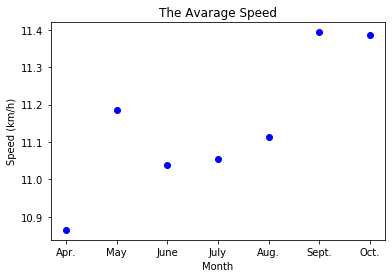

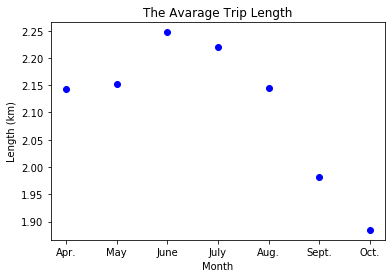

In [7]:
def speed_data(month):
    data = read_data(month)
    data['Speed'] = data['Covered_distance_(m)']/data['Duration_(sec.)']
    return data

def speed_mean(month):
    data = speed_data(month)
    return data['Speed'].mean()

def draw_speed():
    speeds = [speed_mean("04"),speed_mean("05"), speed_mean("06"),speed_mean("07"),speed_mean("08"),speed_mean("09"),speed_mean("10")]
    speed_km_h =[i * 3.6 for i in speeds]
    months = ["Apr.","May","June","July","Aug.","Sept.","Oct."]
    plt.plot(months, speed_km_h, 'bo')
    plt.xlabel('Month')
    plt.ylabel('Speed (km/h)')
    plt.title('The Avarage Speed')
    plt.show()


def mean_trip(month):
    data = read_data(month)
    return data['Covered_distance_(m)'].mean()

def draw_trip_length():
    means = [ mean_trip("04"), mean_trip("05"),  mean_trip("06"), mean_trip("07"), mean_trip("08"),  mean_trip("09"),  mean_trip("10")]
    mean_km =[i / 1000 for i in means]
    months = ["Apr.","May","June","July","Aug.","Sept.","Oct."]
    plt.plot(months, mean_km, 'bo')
    plt.xlabel('Month')
    plt.ylabel('Length (km)')
    plt.title('The Avarage Trip Length')
    plt.show()

def sum_trip_length():
    data = year_data()
    return data['Covered_distance_(m)'].sum()

def to_the_moon():
    length = sum_trip_length()/1000
    moon_distance = 384400
    return  length/moon_distance

if __name__ == "__main__":
    print(f"The sum of the covered distances is {sum_trip_length()/1000}km")
    print(f"That is same than {to_the_moon()/2} jorney to the moon and back.")
    draw_speed()
    draw_trip_length()


Poljettuja kilometrejä tulee yhteensä noin 7 900 000 kilometriä. Kuuhun matkaa on 384 400 kilometria, joten poljetuilla kilometreillä pääsisi kuuhun ja takaisin 10 kertaa.

Keskinopeuksissa on havaittavana kiinnostava ilmiö. Syyskuussa ja lokakuussa nopeus on ollut keskimäärin nopeammin kuin kesäkuukausina. Toisaalta matkojen pituus on laskenut syksyä kohden mentäessä. Matkojen pituus ja nopeus näyttäisivät korreloivan keskenään. Lyhyemmällä matkalla luonnollisesti jaksaa polkea nopeampaa kuin pitkällä. Lasketaan näille Pearsonin korrelaatiokerroin funktiossa ```corr_speed_length()```.  

In [8]:
def corr_speed_length():
    length = [ mean_trip("04"), mean_trip("05"),  mean_trip("06"), mean_trip("07"), mean_trip("08"),  mean_trip("09"),  mean_trip("10")]
    speed = [speed_mean("04"),speed_mean("05"), speed_mean("06"),speed_mean("07"),speed_mean("08"),speed_mean("09"),speed_mean("10")]
    return pearsonr(length,speed)

if __name__ == "__main__":
    print(corr_speed_length())


(-0.794574627547916, 0.0327749273053754)


Korrelaatiokertoimeksi saatiin noin -0.795. Tämän datan perusteella voitaisiin sanoa, että pyöräilynopeus ja matka ovat kääntäen verrannollisia keskenään. 

## Matkan kesto

Pyörää voi käyttää 30min ilman lisämaksuja. Piirretää pyöräilyaika 30min jälkeen. Kuvaajassa y-akselilla on pyöräilijöiden määrä ja x-akselilla aika.    

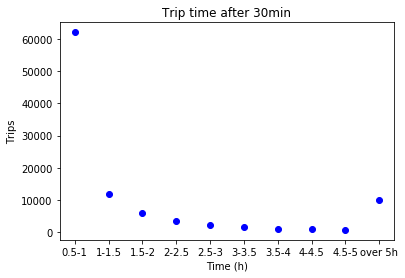

In [5]:
def time_between(start,end):
    data = year_data()
    return len(data[(data['Duration_(sec.)']>=start*60 ) & (data['Duration_(sec.)']<=end*60)])

def draw_freq_time():
    counts = [time_between(31,60),time_between(61,90) ,time_between(91,120),time_between(121,150), time_between(151,180), time_between(181,210), time_between(211,240),time_between(241,270),time_between(271,300),time_between(301,6000000)] 
    x = ["0.5-1","1-1.5","1.5-2","2-2.5","2.5-3","3-3.5","3.5-4","4-4.5","4.5-5","over 5h"]
    plt.plot(x, counts, 'bo')
    plt.xlabel('Time (h)')
    plt.ylabel('Trips')
    plt.title('Trip time after 30min')
    plt.show()
                                            
if __name__ == "__main__":
    time_between(0,30)
    draw_freq_time()
    

Huomataan kuvaajasta, että selvästi suurin osa pyöräilijöistä palautti pyörän ensimmäisen 30min sisällä. Palautusmäärät laskevat rajusti seuraavan puolen tunnin jälkeen. Laskua määristä tapahtuu tasaisesti paitsi yli viiden tunnin palautuksia on taas enemmän. Voi olla mahdollista, että näidne pyörien palautuksessa on ollut jotakin ongelmaa.  